In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
from sklearn.metrics import confusion_matrix

In [23]:
# Load the dataset
file_path = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv'

df = pd.read_csv(file_path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [24]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [25]:
df.duplicated().sum()

np.int64(0)

In [26]:
df.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

In [27]:
# Drop rows with missing values
df.dropna(inplace=True)

In [28]:
df.nunique()

species                3
island                 3
bill_length_mm       163
bill_depth_mm         79
flipper_length_mm     54
body_mass_g           93
sex                    2
dtype: int64

In [29]:
# Convert categorical variables to numerical
label_encoder = LabelEncoder()
df['species'] = label_encoder.fit_transform(df['species'])
df['island'] = label_encoder.fit_transform(df['island'])
df['sex'] = label_encoder.fit_transform(df['sex'])

In [30]:
df.head()


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,2,39.1,18.7,181.0,3750.0,1
1,0,2,39.5,17.4,186.0,3800.0,0
2,0,2,40.3,18.0,195.0,3250.0,0
4,0,2,36.7,19.3,193.0,3450.0,0
5,0,2,39.3,20.6,190.0,3650.0,1


In [46]:
# Split the data into features and target
X = df.drop(columns=['species'])
y = df['species']

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((266, 6), (67, 6), (266,), (67,))

In [37]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.long)
# Create a dataset and dataloader
train_dataset = TensorDataset(X_tensor, y_tensor)
batch_size = 32
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Check the GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Check the GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [38]:
# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return self.softmax(x)

In [39]:
# Initialize the model, loss function, and optimizer
input_size = X.shape[1]
output_size = len(np.unique(y))
model = SimpleNN(input_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [40]:
# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.5939
Epoch [20/100], Loss: 0.5583
Epoch [30/100], Loss: 0.5538
Epoch [40/100], Loss: 0.5541
Epoch [50/100], Loss: 0.5644
Epoch [60/100], Loss: 0.5538
Epoch [70/100], Loss: 0.5562
Epoch [80/100], Loss: 0.5516
Epoch [90/100], Loss: 0.5515
Epoch [100/100], Loss: 0.5516


In [42]:
# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [44]:
# 모델 확습
train_losses = []
train_accuracies = []

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

Epoch [1/100], Loss: 0.5526, Accuracy: 1.0000
Epoch [2/100], Loss: 0.5525, Accuracy: 1.0000
Epoch [3/100], Loss: 0.5522, Accuracy: 1.0000
Epoch [4/100], Loss: 0.5521, Accuracy: 1.0000
Epoch [5/100], Loss: 0.5520, Accuracy: 1.0000
Epoch [6/100], Loss: 0.5520, Accuracy: 1.0000
Epoch [7/100], Loss: 0.5520, Accuracy: 1.0000
Epoch [8/100], Loss: 0.5519, Accuracy: 1.0000
Epoch [9/100], Loss: 0.5519, Accuracy: 1.0000
Epoch [10/100], Loss: 0.5518, Accuracy: 1.0000
Epoch [11/100], Loss: 0.5518, Accuracy: 1.0000
Epoch [12/100], Loss: 0.5518, Accuracy: 1.0000
Epoch [13/100], Loss: 0.5518, Accuracy: 1.0000
Epoch [14/100], Loss: 0.5520, Accuracy: 1.0000
Epoch [15/100], Loss: 0.5518, Accuracy: 1.0000
Epoch [16/100], Loss: 0.5520, Accuracy: 1.0000
Epoch [17/100], Loss: 0.5518, Accuracy: 1.0000
Epoch [18/100], Loss: 0.5517, Accuracy: 1.0000
Epoch [19/100], Loss: 0.5517, Accuracy: 1.0000
Epoch [20/100], Loss: 0.5517, Accuracy: 1.0000
Epoch [21/100], Loss: 0.5517, Accuracy: 1.0000
Epoch [22/100], Loss: 

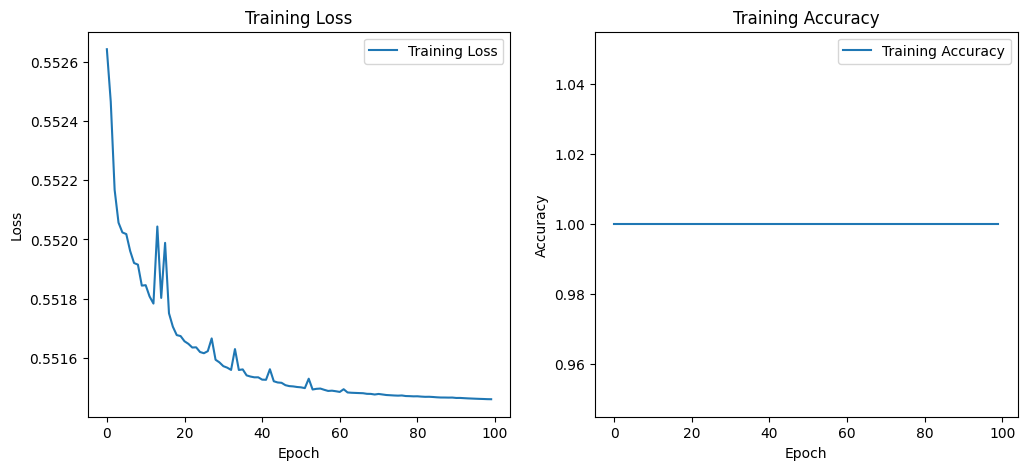

In [48]:
# Plot the training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()
